### Multi Head Attention

In [14]:
import numpy as np 
import pandas as pd 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size,sequence_length, input_dim))

In [5]:
x.size()

torch.Size([1, 4, 512])

In [7]:
qkv_layer = nn.Linear(input_dim,3 * d_model)
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

In [8]:
qkv

tensor([[[-0.2017,  1.1068,  0.0260,  ..., -1.1974, -0.5606,  0.9321],
         [-0.5236, -0.3487,  0.2872,  ...,  0.4473, -0.2781,  0.8835],
         [-1.4264, -0.4598, -0.0927,  ...,  1.1395, -0.9284,  0.0876],
         [ 0.9463,  0.1999, -0.7228,  ...,  0.3074, -0.0309, -0.3068]]],
       grad_fn=<ViewBackward0>)

Text(0.5, 1.0, 'qkv distribution')

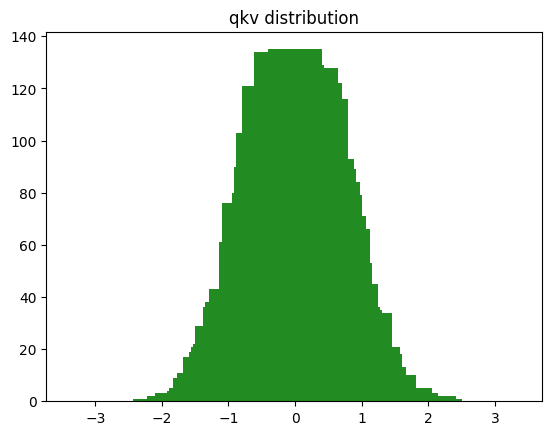

In [9]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [10]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size , sequence_length , num_heads , 3*head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

In [16]:
d_k = q.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [17]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [20]:
y = torch.randn(2,3)
print(y)
torch.transpose(y , 1 , 0)

tensor([[ 0.4816, -0.7550, -0.7410],
        [-0.2392, -0.5091,  0.7270]])


tensor([[ 0.4816, -0.2392],
        [-0.7550, -0.5091],
        [-0.7410,  0.7270]])

In [22]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [23]:
k.transpose(-1, -2).shape , k.transpose(-2, -1).shape

(torch.Size([1, 8, 64, 4]), torch.Size([1, 8, 64, 4]))

In [28]:
mask = torch.full(scaled.size() ,float('-inf'))
mask = torch.triu(mask , diagonal=1)
print(mask.shape)
mask[0][1]

torch.Size([1, 8, 4, 4])


tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [29]:
(scaled + mask)[0][0]

tensor([[ 0.2375,    -inf,    -inf,    -inf],
        [ 0.3853, -0.0981,    -inf,    -inf],
        [-0.2778,  0.4048,  0.5006,    -inf],
        [-0.2462,  0.1624, -0.3263,  0.0839]], grad_fn=<SelectBackward0>)

In [30]:
scaled += mask

In [32]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [35]:
attention = F.softmax(scaled, dim=-1)
attention.shape

torch.Size([1, 8, 4, 4])

In [36]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6186, 0.3814, 0.0000, 0.0000],
        [0.1939, 0.3838, 0.4223, 0.0000],
        [0.2075, 0.3122, 0.1915, 0.2887]], grad_fn=<SelectBackward0>)

In [37]:
values = torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [38]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention
    

In [40]:
values, attention = scaled_dot_product(q, k, v, mask=mask)
values.shape, attention.shape

(torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 4, 4]))

In [41]:
attention.shape

torch.Size([1, 8, 4, 4])

In [44]:
attention[0][3]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6339, 0.3661, 0.0000, 0.0000],
        [0.3593, 0.3458, 0.2949, 0.0000],
        [0.2159, 0.2298, 0.2488, 0.3056]], grad_fn=<SelectBackward0>)

In [45]:
values.shape

torch.Size([1, 8, 4, 64])

In [47]:
values[0][1]

tensor([[-1.5142e-02, -4.8592e-01, -4.8775e-01, -1.1860e-01, -9.3277e-01,
         -1.0998e+00, -1.1298e+00, -9.5773e-02,  5.5119e-01, -5.6895e-01,
         -3.6001e-01,  3.7907e-01,  7.7693e-01, -1.5217e-01, -1.1263e+00,
          1.9349e-02, -6.3687e-01,  9.7181e-02,  1.5596e-01, -8.0707e-01,
          9.7127e-02, -3.0956e-02,  1.2549e+00,  7.2740e-01,  7.1831e-01,
          2.1477e-01, -4.7388e-01, -3.2426e-01,  3.3248e-01,  7.0756e-01,
          1.7729e-01, -1.0177e+00, -4.3114e-01,  6.7719e-01, -6.1016e-01,
          6.5727e-01, -8.5627e-01, -1.3770e+00, -5.6093e-01, -3.7432e-01,
         -1.3737e+00,  9.9558e-01,  4.1240e-02, -4.3450e-01, -1.0823e+00,
         -6.4076e-01, -4.9675e-01, -7.3843e-01,  4.7464e-01, -9.3642e-01,
         -1.1230e+00, -1.2950e-01,  3.2031e-01,  1.8081e-02, -3.8488e-01,
          5.3034e-02,  6.4935e-01, -1.5207e-01, -7.4602e-02,  3.4790e-01,
         -5.4829e-02,  1.1093e+00, -3.4864e-01,  6.8235e-01],
        [-3.6325e-01,  1.8120e-01, -5.9729e-01,  7

In [48]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [49]:
linear_layer = nn.Linear(d_model,d_model)

In [50]:
out = linear_layer(values)
out.shape


torch.Size([1, 4, 512])

In [51]:
out

tensor([[[-0.6338, -0.0215, -0.4086,  ..., -0.3895, -0.3378, -0.1123],
         [-0.4972,  0.2225,  0.0382,  ...,  0.0462,  0.0242, -0.2343],
         [-0.1701, -0.2749,  0.0717,  ..., -0.1998, -0.3026, -0.0630],
         [-0.1397,  0.0029, -0.0619,  ..., -0.1025,  0.0604,  0.3012]]],
       grad_fn=<ViewBackward0>)

## Class

In [53]:
import torch
import torch.nn as nn
import math

# Define the scaled dot product attention function
def scaled_dot_product(q, k, v, mask=None):
    # Get the dimension of the key vectors
    d_k = q.size()[-1]
    
    # Calculate the scaled dot product attention
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    
    # Add the mask if provided
    if mask is not None:
        scaled += mask
    
    # Apply the softmax to obtain attention weights
    attention = F.softmax(scaled, dim=-1)
    
    # Calculate the weighted sum using attention weights
    values = torch.matmul(attention, v)
    
    return values, attention

# Define the MultiheadAttention module
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Linear layer for Q, K, V
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        
        # Linear layer after concatenating the outputs from different heads
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        # Get dimensions of the input tensor
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        # Linear transformation for Q, K, V
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        
        # Reshape the tensor to split into Q, K, V for each head
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
                
        # Permute the dimensions for matrix multiplication
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
                
        # Split into Q, K, V
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
                
        # Apply scaled dot product attention
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
                
        # Reshape values and apply linear transformation
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")

        return out


### Input

In [54]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
